In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Preparing Data

In [12]:
link_data = 'https://github.com/leonv1602/scraping-ibpa-data/raw/main/Scrape%20PHEI/2023-Desember/Bond-Data-22-Desember-2023.xlsx'
df = pd.read_excel(link_data).iloc[:, 1:]
df.iloc[:, 2:-1] /= 100
df.sort_values(df.columns[1], ascending = True, inplace = True)
df.reset_index(drop = True, inplace = True)
df

,Series,TTM (Y),Today Yield (%),Today Price (%),Yesterday Yield (%),Yesterday Price (%),Coupon (%),type
0,ORI019,0.15,0.064295,0.998736,0.064080,0.998746,0.05570,retail
1,SR014,0.22,0.064305,0.997926,0.064103,0.997944,0.05470,retail
2,SR015,0.72,0.064290,0.990700,0.064111,0.990791,0.05100,retail
3,ORI020,0.82,0.064918,0.987798,0.064827,0.987831,0.04950,retail
4,ORI021,1.15,0.065856,0.981412,0.065692,0.981550,0.04900,retail
5,SR016,1.22,0.063874,0.983200,0.064368,0.982591,0.04950,retail
6,PBS036,1.65,0.066366,0.980500,0.066088,0.980892,0.05375,sbsn
7,SR017,1.72,0.064500,0.991076,0.064798,0.990582,0.05900,retail
8,ORI022,1.82,0.063957,0.992381,0.064383,0.991645,0.05950,retail
9,SR018T3,2.22,0.065714,0.993381,0.065822,0.993151,0.06250,retail


Index(['retail', 'sbsn', 'sbn'], dtype='object')

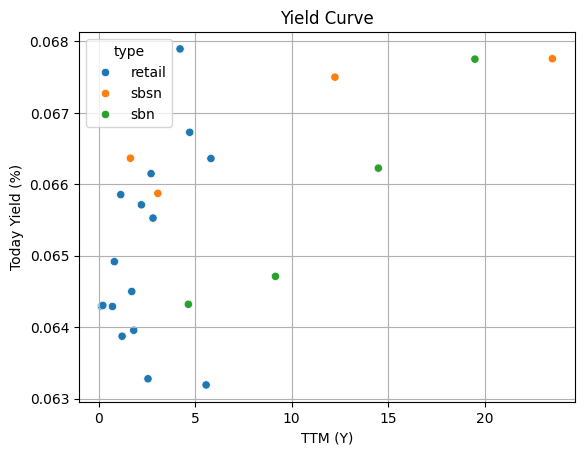

In [24]:
sns.scatterplot(data=df, x='TTM (Y)', y='Today Yield (%)', hue='type')
plt.title('Yield Curve')
plt.grid()
plt.show()

# Nelson Siegel Model

\begin{equation}
\hat{y} := \beta_0 + \beta_1 \exp{\frac{-\tau}{\lambda}} + \beta_2 \frac{\tau}{\lambda} \exp{-\frac{\tau}{\lambda}}
\end{equation}
with $\tau$ is time to maturity and others as model's parameters. 

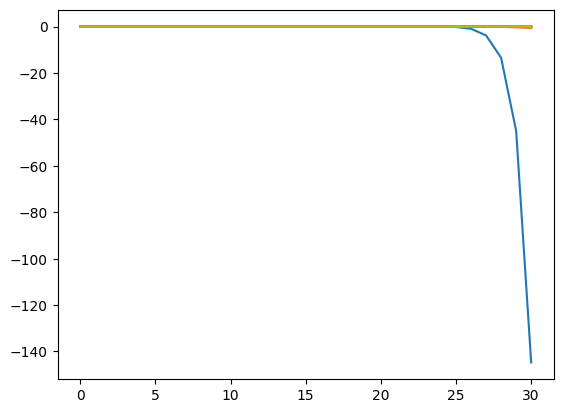

In [60]:
# Assume Lambda is contants, that is 0.5

tau = df['TTM (Y)'].values
y = df['Today Yield (%)'].values

def matrix_design(tau, lambda_):
    return np.array([[1]*len(tau), np.exp(tau/lambda_), tau/lambda_*np.exp(tau/lambda_)])

def ns_model(tau, y, lambda_):
    X = matrix_design(tau, lambda_)
    params = np.linalg.inv(X.dot(X.T)).dot(X).dot(y)
    return X, params

error_list = []
lambda_test = np.arange(1, 10)
for i in range(len(lambda_test)):
    X_ ,params_ = ns_model(tau = tau, y = y, lambda_ = lambda_test[i]) 
    error_list.append((X_.T.dot(params_)/y-1))
    tau_hypothetical = np.arange(31)
    matrix_hypothetical = matrix_design(tau = tau_hypothetical, lambda_ = lambda_test[i])
    y_hat = matrix_hypothetical.T.dot(params_)
    plt.plot(tau_hypothetical, y_hat)
plt.show()

In [61]:
np.sum(error_list, axis = 1)

array([0.00834626, 0.0080376 , 0.00762623, 0.00737286, 0.00724832,
       0.00718668, 0.00715352, 0.00713395, 0.00712139])

# Linear Smoothing

Basic Mathematical notation:
\begin{align*}
r(t) &= \frac{t-t_{i-1}}{t_i - t_{i-1}} r_i + \frac{t_{i}-t}{t_i - t_{i-1}} r_{i-1} \\
&= \frac{1}{t_i - t_{i-1}}\left( \left(t-t_{i-1}  \right) r_i+  \left(t_{i}-t\right) r_{i-1}\right) \\
&= \frac{ t_{i-1} r_i + t_{i} r_{i-1} - t \left( r_i -  r_{i-1}\right)}{t_i - t_{i-1}} 
\end{align*}

In [ ]:
maturity = np.array([i for i in range(1,31)])
tenor = df['TTM (Y)'].values
rate = df['Today Yield (%)'].values
def linear_method(tenor, rate, t): 
    smooth = []
    for i in range(len(t)):
        lower = min(i,len(rate)-2)
        upper = min(i+1,len(rate)-1)
        smooth.append((rate[upper]*(t[i] - tenor[lower])+rate[lower]*(tenor[upper] - t[i]))/(tenor[upper]-tenor[lower]))
    return smooth

In [ ]:
def sampling(population, yield_rate):
    unique = np.unique(np.ceil(population))
    n = len(unique)
    sample = ([],[])
    for i in range(n):
        sample[0].append(population[np.random.choice(np.where(np.ceil(population) == unique[i])[0])])
        sample[1].append(yield_rate[np.random.choice(np.where(np.ceil(population) == unique[i])[0])])
    return sample

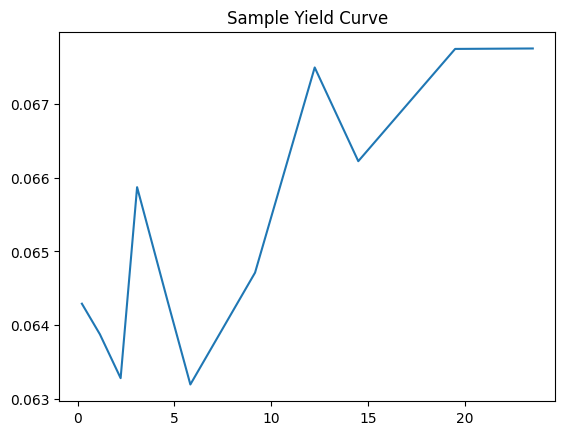

In [ ]:
sample_tenor, sample_yield = sampling(tenor, rate)

plt.plot(sample_tenor, sample_yield)
plt.title('Sample Yield Curve')
plt.show()

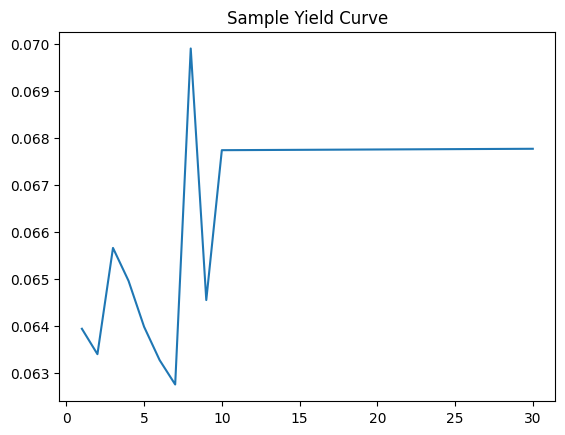

In [ ]:
smoothed_yield = linear_method(sample_tenor, sample_yield, maturity)
plt.plot(maturity, smoothed_yield)
plt.title('Sample Yield Curve')
plt.show()